# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dependencies

In [ ]:
!pip install unidecode

In [ ]:
train_df_path           = "data/train.tsv"
test_df_path            = "data/test.tsv"
test_stage_2_df_path    = "data/test_stg2.tsv"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import regex as re
import unidecode
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from nltk.stem import PorterStemmer 
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import csr_matrix
from nltk import word_tokenize, pos_tag, ne_chunk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
import itertools
import multiprocessing
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import gc
from tensorflow.keras.utils import plot_model

num_cores = multiprocessing.cpu_count()
num_cores


2

# Data Reading

In [ ]:
df  = pd.read_table("/content/drive/MyDrive/CASE STUDY - 1/data/train.tsv")
# test_df   = pd.read_table("data/test.tsv")
# test_2_df = pd.read_table("data/test_stg2.tsv")
# submission_1 = pd.read_csv("data/sample_submission.csv")
# submission_2 = pd.read_csv("data/sample_submission_stg2.csv")

In [ ]:
df.shape

(1482535, 8)

In [ ]:
df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [ ]:
df.iloc[[1]]['price']

1    52.0
Name: price, dtype: float64

In [ ]:
df.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool

In [ ]:
df['name'][619553]

'4pcs sugar lip scrubs'

In [ ]:
num_cores = multiprocessing.cpu_count()
num_cores

2

In [ ]:
df.loc[1360970]

train_id                                           1360970
name                                                     ✨
item_condition_id                                        2
category_name                            Women/Skirts/Mini
brand_name                                 Brandy Melville
price                                                   24
shipping                                                 0
item_description     •Perfect condition ! •FIRM #John Galt
Name: 1360970, dtype: object

# Missing Values 

In [ ]:
df['brand_name'].fillna("unknown", inplace=True)

df['category_name'].fillna("unknown/unknown/unknown", inplace=True)

df['item_description'].fillna("no description yet", inplace=True)

df['cat_1'] = df.category_name.str.split('/').str.get(0).astype('category')
df['cat_2'] = df.category_name.str.split('/').str.get(1).astype('category')
df['cat_3'] = df.category_name.str.split('/').str.get(2).astype('category')


In [ ]:
global setofBrands 
setofBrands = np.unique(df['brand_name'].astype(str).str.lower())


global setofCat1
setofCat1 = np.unique(df['cat_1'].astype(str).str.lower())

global setofCat2
setofCat2 = np.unique(df['cat_2'].astype(str).str.lower())

global setofCat3
setofCat3 = np.unique(df['cat_3'].astype(str).str.lower())

In [ ]:
# https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe

# concat cat_1, cat_2, cat_3 
def concat_c1_c2_c3(c_1, c_2, c_3):
    return c_1 + "_" + c_2 + "_" + c_3


# filling missing cat_1 column from item_description and name
def miss_cat1(row):
    
    cat1 = row['cat_1']
    
    if row['cat_1']=='unknown':
        
        for i in setofCat1:
            if i in row['item_description'].lower():
                
                # print("1 desc {}".format(i))
                
                cat1 = i
                break
            elif i in row['name'].lower():
                
                # print("1 name {}".format(i))
                
                cat1 = i
                break   
    
    return cat1


## filling missing cat_2 column from item_description and name
def miss_cat2(row):
    
    cat2 = row['cat_2']
    
    if row['cat_2']=='unknown':
        
        for i in setofCat2:
            if i in row['item_description'].lower():
                
                # print("2 desc {}".format(i))
                
                cat2 = i
                break
            elif i in row['name'].lower():
                
                # print("2 name {}".format(i))
                
                cat2 = i
                break   
    
    return cat2


## filling missing cat_3 column from item_description and name
def miss_cat3(row):
    
    cat3 = row['cat_3']
    
    if row['cat_3']=='unknown':
        
        for i in setofCat3:
            if i in row['item_description'].lower():
                
                # print("3 desc {}".format(i))
                
                cat3 = i
                break
            elif i in row['name'].lower():
                
                # print("3 name {}".format(i))
                
                cat3 = i
                break   
    
    return cat3
    

## get missing brand name from name and description
def miss_brand(row):
    
    brand_name = row['brand_name']
    desc = row['item_description'].lower()
    name = row['name'].lower()
    
    if row['brand_name']=='unknown':
        
        for i in setofBrands:
            if i in desc:
                                
                brand_name = i
                break
            elif i in name:
                
                brand_name = i
                break   
    
    return brand_name


def fill_missing_data(df):
    
    df['cat_1']         = df.apply(miss_cat1, axis=1)
    df['cat_2']         = df.apply(miss_cat2, axis=1)
    df['cat_3']         = df.apply(miss_cat3, axis=1)
    df['brand_name']    = df.apply(miss_brand, axis=1)
    df['category_name'] = df.apply(lambda x: concat_c1_c2_c3(str(x.cat_1), str(x.cat_2), str(x.cat_3)), axis=1)
    
    return df

In [ ]:

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as pool:
        df = pd.concat(pool.map(func, df_split))
    return df


In [ ]:
%%time
df = parallelize_dataframe(df, fill_missing_data)

CPU times: user 4.07 s, sys: 1.43 s, total: 5.5 s
Wall time: 4min 9s


# Cleaning

In [ ]:
df['item_description']

0                                         No description yet
1          This keyboard is in great condition and works ...
2          Adorable top with a hint of lace and a key hol...
3          New with tags. Leather horses. Retail for [rm]...
4                  Complete with certificate of authenticity
                                 ...                        
1482530    Lace, says size small but fits medium perfectl...
1482531     Little mermaid handmade dress never worn size 2t
1482532            Used once or twice, still in great shape.
1482533    There is 2 of each one that you see! So 2 red ...
1482534    New with tag, red with sparkle. Firm price, no...
Name: item_description, Length: 1482535, dtype: object

In [ ]:
num_word_dict = {
    
    "0":"zero",
    "1":"one",
    "2":"tow",
    "3":"three",
    "4":"four",
    "5":"five",
    "6":"six",
    "7":"seven",
    "8":"eight",
    "9":"nine",
    '+':'plus'
}

def number_to_word(text):
    sentence = ''
    for letter in text:
        try:
            
            if letter.isdigit():
                sentence = sentence + ' ' + num_word_dict[letter]
            else:
                sentence = sentence + letter
        except:
            sentence = sentence + ''
            
    return sentence

def accented_to_english(text):
    return unidecode.unidecode(text)

def fill_description(text):
    if len(text) == 0:
        return "no description yet"
    else:
        return text

def fill_name(text):
    if len(text) == 0:
        return "no name"
    else:
        return text
    
def remove_stop_words(sent):
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]
    
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    return sent

def decontracted(phrase):
    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def remove_line(sent):
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    
    return sent

def setmming(sent):
    ps = PorterStemmer()

def preprocess_cleaning(df):
    
    df['name'] = df['name'].apply(decontracted)
    df['name'] = df['name'].apply(remove_line)
    df['name'] = df['name'].apply(accented_to_english)
    df['name'] = df['name'].str.replace(r'[^A-Za-z0-9 ]', r' ')
    # df['name'] = df['name'].apply(number_to_word)
    df['name'] = df['name'].str.strip()
    df['name'] = df['name'].str.replace(' +', ' ')
    df['name'] = df['name'].str.lower()
    df['name'] = df['name'].apply(fill_name)
    
  
    df['brand_name'] = df['brand_name'].str.replace(r'[^A-Za-z0-9 ]', r' ')# remove all char except words and letters
    df['brand_name'] = df['brand_name'].str.strip()# removing leading and tailing spaces
    df['brand_name'] = df['brand_name'].str.replace(' +', ' ')# replacing double_space with single space
    df['brand_name'] = df['brand_name'].str.replace(' ', '_')# replacing space with under_score
    df['brand_name'] = df['brand_name'].str.lower()# converting to lowercase
    

    df['cat_1'] = df['cat_1'].apply(accented_to_english)
    df['cat_1'] = df['cat_1'].str.replace(r'[^A-Za-z0-9 ]', r' ')# remove all char except words and letters
    df['cat_1'] = df['cat_1'].apply(remove_line)
    df['cat_1'] = df['cat_1'].str.strip()# removing leading and tailing spaces
    df['cat_1'] = df['cat_1'].str.replace(' +', ' ')# replacing double_space with single space
    df['cat_1'] = df['cat_1'].str.replace(' ', '_')# replacing space with under_score
    df['cat_1'] = df['cat_1'].str.lower()# converting to lowercase
 
    df['cat_2'] = df['cat_2'].apply(accented_to_english)
    df['cat_2'] = df['cat_2'].str.replace(r'[^A-Za-z0-9 ]', r' ')# remove all char except words and letters
    # df['cat_2'] = df['cat_2'].apply(number_to_word)# converting number to letter
    df['cat_2'] = df['cat_2'].str.strip()# removing leading and tailing spaces
    df['cat_2'] = df['cat_2'].str.replace(' +', ' ')# replacing double_space with single space
    df['cat_2'] = df['cat_2'].str.replace(' ', '_')# replacing space with under_score
    df['cat_2'] = df['cat_2'].str.lower()# converting to lowercase
    

    df['cat_3'] = df['cat_3'].apply(accented_to_english)
    df['cat_3'] = df['cat_3'].str.replace(r'[^A-Za-z0-9 ]', r' ')# remove all char except words and letters
    #df['cat_3'] = df['cat_3'].apply(number_to_word)# converting number to letter
    df['cat_3'] = df['cat_3'].str.strip()# removing leading and tailing spaces
    df['cat_3'] = df['cat_3'].str.replace(' +', ' ')# replacing double_space with single space
    df['cat_3'] = df['cat_3'].str.replace(' ', '_')# replacing space with under_score
    df['cat_3'] = df['cat_3'].str.lower()# converting to lowercase
    
    df['category_name'] = df['cat_1'] + "_" + df['cat_2'] + "_" + df['cat_3']
    
    df['item_description'] = df['item_description'].apply(decontracted)
    df['item_description'] = df['item_description'].apply(remove_line)
    # df['item_description'] = df['item_description'].apply(remove_stop_words)
    df['item_description'] = df['item_description'].apply(accented_to_english)
    df['item_description'] = df['item_description'].str.replace(r'[^a-zA-Z0-9 ]', r' ')# remove all char except words and letters
    df['item_description'] = df['item_description'].str.strip()# removing leading and tailing spaces
    df['item_description'] = df['item_description'].str.replace(' +', ' ')# replacing double_space with single space
    df['item_description'] = df['item_description'].str.lower()# converting to lowercase
    df['item_description'] = df['item_description'].apply(fill_description)
    
    return df


In [ ]:
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    with Pool(num_cores) as pool:
        df = pd.concat(pool.map(func, df_split))
    return df

In [ ]:
%%time
df = parallelize_dataframe(df, preprocess_cleaning)

CPU times: user 5.96 s, sys: 2.14 s, total: 8.09 s
Wall time: 3min 2s


# Train Test Split

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)

In [ ]:
train_df.shape, test_df.shape

((1186028, 11), (296507, 11))

# Feature Engineering

## Brand Category

In [ ]:
%%time
def brand_category_func(price):

    if price > 4:
        return "expensive"
    elif price > 2 and price < 4:
        return "affordable"
    elif price < 2:
        return "cheap"
    
    
    
def create_brand_category(df):
    df['brand_category'] = df.apply(lambda x: brand_category_func(np.log1p(x.price)), axis=1)
    return df


train_df = parallelize_dataframe(train_df, create_brand_category)


CPU times: user 8.27 s, sys: 2.32 s, total: 10.6 s
Wall time: 31.4 s


In [ ]:
def test_brand_category(train_df, test_df):
    
    expensive_brands = np.unique(train_df[train_df['brand_category']=='expensive']['brand_name'].values)
    affordable_brands = np.unique(train_df[train_df['brand_category']=='affordable']['brand_name'].values)
    cheap_brands = np.unique(train_df[train_df['brand_category']=='cheap']['brand_name'].values)
    
    def test_brand_category_func(brand, expensive_brands, affordable_brands, cheap_brands):
        
        if brand in expensive_brands:
            return 'expensive'
        elif brand in affordable_brands:
            return 'affordable'
        else:
            return 'cheap'
    
    test_df['brand_category'] = test_df.apply(lambda x: test_brand_category_func(str(x.brand_name),expensive_brands ,affordable_brands ,cheap_brands), axis=1)

    return test_df

In [ ]:
test_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'cat_1', 'cat_2', 'cat_3'],
      dtype='object')

In [ ]:

%%time

test_df = test_brand_category(train_df, test_df)


CPU times: user 27.9 s, sys: 318 ms, total: 28.2 s
Wall time: 27.9 s


## Extra features

In [ ]:
def create_features(df):
    
    df['desc_word_count'] = (df['item_description'].str.count("\s+")+1).fillna(0).astype(np.float32)
    
    df['desc_char_count'] = df['item_description'].str.len().fillna(0).astype(np.float32)
    
    df['name_word_count'] = (df['name'].str.count("\s+")+1).fillna(0).astype(int)
    
    df['name_char_count'] = df['name'].str.len().fillna(0).astype(int)
    
    df['brand_count'] = df['brand_name'].map(df["brand_name"].value_counts()).fillna(0).astype(int)
    
    df['cat_count'] = df['category_name'].map(df["category_name"].value_counts()).fillna(0).astype(int)
    
    df['cat_1_count'] = df['cat_1'].map(df["cat_1"].value_counts()).fillna(0).astype(int)
    
    df['cat_2_count'] = df['cat_2'].map(df["cat_2"].value_counts()).fillna(0).astype(int)
    
    df['cat_3_count'] = df['cat_3'].map(df["cat_3"].value_counts()).fillna(0).astype(int)
    
    df["brand_cat"] = (df["brand_name"].astype(str) + ' ' + df["category_name"].astype(str)).astype('category')
    
    df["cat_cond"] = (df["category_name"].astype(str) + ' ' + df["item_condition_id"].astype(str)).astype('category')
    
    df["brand_cond"] = (df["brand_name"].astype(str) + ' ' + df["item_condition_id"].astype(str)).astype('category')
    
    df["cat_shipping"] = (df["category_name"].astype(str) + ' ' + df["shipping"].astype(str)).astype('category')
    
    df["brand_cat_count"] = df['brand_cat'].map(df["brand_cat"].value_counts()).fillna(0).astype(int) 
    
    df['name_and_brand'] = df['name'].fillna("")+ " " + df['brand_name'].fillna("")
    
    df['name_and_desc_and_category'] = df['name'].fillna('') + " " + df['item_description'].fillna("")+ " " + df['category_name'].fillna("")


    return df
    

In [ ]:
%%time

train_df = parallelize_dataframe(train_df, create_features)


CPU times: user 8.04 s, sys: 2.82 s, total: 10.9 s
Wall time: 32.2 s


In [ ]:
%%time

test_df = parallelize_dataframe(test_df, create_features)

CPU times: user 2.67 s, sys: 1.64 s, total: 4.3 s
Wall time: 10.1 s


In [ ]:
train_cleaned_path = "/content/drive/MyDrive/CASE STUDY - 1/data/ann_train_cleaned.csv"
test_cleaned_path = "/content/drive/MyDrive/CASE STUDY - 1/data/ann_test_cleaned.csv"

train_df.to_csv(train_cleaned_path, index=False)
test_df.to_csv(test_cleaned_path, index=False)

# Cleaned Data

In [ ]:
!pip install Unidecode

     |████████████████████████████████| 245kB 17.9MB/s 


In [ ]:
# train_df_path           = "data/train.tsv"
# test_df_path            = "data/test.tsv"
# test_stage_2_df_path    = "data/test_stg2.tsv"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import regex as re
import unidecode
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from nltk.stem import PorterStemmer 
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import csr_matrix
from nltk import word_tokenize, pos_tag, ne_chunk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
import itertools
import multiprocessing
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import gc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, GRU, LSTM, Dense, BatchNormalization, Dropout, RNN, Flatten, GlobalAveragePooling1D, concatenate, PReLU, Concatenate
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2, l1_l2


num_cores = multiprocessing.cpu_count()
num_cores


2

In [ ]:
train_cleaned_path = "/content/drive/MyDrive/CASE STUDY - 1/data/ann_train_cleaned.csv"
test_cleaned_path = "/content/drive/MyDrive/CASE STUDY - 1/data/ann_test_cleaned.csv"


train_df = pd.read_csv(train_cleaned_path)
test_df = pd.read_csv(test_cleaned_path)

In [ ]:
train_df = train_df[train_df['price']!=0]
test_df  = test_df[test_df['price']!=0]

In [ ]:
train_df['log_price'] = np.log1p(train_df['price'].values.astype(np.float32))
test_df['log_price'] = np.log1p(test_df['price'].values.astype(np.float32))

In [ ]:

y = train_df['log_price'].to_numpy().reshape(-1, 1)
y_test = test_df['log_price'].to_numpy().reshape(-1, 1)


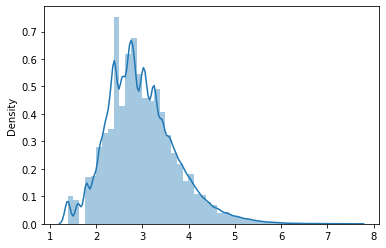

In [ ]:
import seaborn as sns

sns.distplot(y_test)

In [ ]:
len(train_df['brand_name'].value_counts())

4598

In [ ]:
train_df['brand_name'].value_counts()

and                  155153
all                  116920
pink                  44243
nike                  43629
victoria_s_secret     38470
                      ...  
fashion_fair              1
positive_attitude         1
sere_nade                 1
uncle_milton              1
clean_clear               1
Name: brand_name, Length: 4598, dtype: int64

In [ ]:
i = np.array(train_df['brand_name'].value_counts().index)
c = np.array(train_df['brand_name'].value_counts().values)

d = pd.DataFrame({"brand_name":i, "count":c})
d

,brand_name,count
0,and,155153
1,all,116920
2,pink,44243
3,nike,43629
4,victoria_s_secret,38470
...,...,...
4593,fashion_fair,1
4594,positive_attitude,1
4595,sere_nade,1
4596,uncle_milton,1


In [ ]:
d[d['count']==6]

,brand_name,count
2180,grace_karin,6
2181,heritage,6
2182,cyrus,6
2183,mopas,6
2184,denali,6
...,...,...
2321,field_stream,6
2322,gentle_giant,6
2323,godinger,6
2324,all_clad,6


# ANN Model

## Factorization Machine Model

In [ ]:
filter = '[a-z][\w&]*|[\d]+[\.]*[\w]*|[/!?*:%$"\'\-\+=\.,](?![/!?*:%$"\'-\+=\.,])'

In [ ]:
embeddings_index = {}
f = open('/content/drive/MyDrive/CASE STUDY - 1/data/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
## Name

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['name']
te = test_df['name'] 

tr_name_desc = train_df['item_description'] + " " + train_df['name']

# c = CountVectorizer(ngram_range=(1,1), min_df=10)
# c.fit(tr)

tokenizer.fit_on_texts(tr_name_desc)

vocab_name = len(tokenizer.word_index)+1

train_name = tokenizer.texts_to_sequences(tr)
test_name  = tokenizer.texts_to_sequences(te)

train_name_padded = pad_sequences(train_name, maxlen=13, padding='post')
test_name_padded = pad_sequences(test_name, maxlen=13, padding='post')


In [ ]:
len(tokenizer.word_index)

180360

In [ ]:
## Brand

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['brand_name'] 
te = test_df['brand_name'] 

tokenizer.fit_on_texts(tr)

vocab_brand = len(tokenizer.word_index)+1

train_brand = tokenizer.texts_to_sequences(tr)
test_brand  = tokenizer.texts_to_sequences(te)

train_brand_padded = pad_sequences(train_brand, maxlen=1, padding='post')
test_brand_padded = pad_sequences(test_brand, maxlen=1, padding='post')


In [ ]:
## Desc

In [ ]:
np.percentile(train_df["desc_word_count"].to_numpy(), 99.99)

196.0

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n_',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['item_description'] 
te = test_df['item_description'] 

# c = CountVectorizer(ngram_range=(1,1), min_df=10)
# c.fit(tr)

tokenizer.fit_on_texts(tr_name_desc)

# tokenizer.word_index = c.vocabulary_
# tokenizer.word_index['<UNK>'] = 1

vocab_desc = len(tokenizer.word_index)+1

train_desc = tokenizer.texts_to_sequences(tr)
test_desc  = tokenizer.texts_to_sequences(te)

train_desc_padded = pad_sequences(train_desc, maxlen=160, padding='post')
test_desc_padded = pad_sequences(test_desc, maxlen=160, padding='post')



In [ ]:
## Category Name

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['category_name'].replace(r'\s+', "_", regex=True)
te = test_df['category_name'].replace(r'\s+', "_", regex=True)

tokenizer.fit_on_texts(tr)

vocab_cat = len(tokenizer.word_index)+1

train_cat = tokenizer.texts_to_sequences(tr)
test_cat  = tokenizer.texts_to_sequences(te)

train_cat_padded = pad_sequences(train_cat, maxlen=1, padding='post')
test_cat_padded = pad_sequences(test_cat, maxlen=1, padding='post')

In [ ]:
## Cat1

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)

tr = train_df['cat_1']
te = test_df['cat_1']

tokenizer.fit_on_texts(tr_name_desc)

vocab_cat1 = len(tokenizer.word_index)+1

train_cat1 = tokenizer.texts_to_sequences(tr)
test_cat1  = tokenizer.texts_to_sequences(te)

train_cat1_padded = pad_sequences(train_cat1, maxlen=1, padding='post')
test_cat1_padded = pad_sequences(test_cat1, maxlen=1, padding='post')

In [ ]:
## Cat2

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['cat_2'] 
te = test_df['cat_2'] 

tokenizer.fit_on_texts(tr_name_desc)

vocab_cat2 = len(tokenizer.word_index)+1

train_cat2 = tokenizer.texts_to_sequences(tr)
test_cat2  = tokenizer.texts_to_sequences(te)

train_cat2_padded = pad_sequences(train_cat2, maxlen=1, padding='post')
test_cat2_padded = pad_sequences(test_cat2, maxlen=1, padding='post')

In [ ]:
## Cat3

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)

tr = train_df['cat_3'] 
te = test_df['cat_3'] 

tokenizer.fit_on_texts(tr_name_desc)

vocab_cat3 = len(tokenizer.word_index)+1

train_cat3 = tokenizer.texts_to_sequences(tr)
test_cat3  = tokenizer.texts_to_sequences(te)

train_cat3_padded = pad_sequences(train_cat3, maxlen=1, padding='post')
test_cat3_padded = pad_sequences(test_cat3, maxlen=1, padding='post')

In [ ]:
## condition

In [ ]:
# vect = LabelEncoder()

train_cond = train_df['item_condition_id'].to_numpy().reshape(-1, 1)
test_cond = test_df['item_condition_id'].to_numpy().reshape(-1, 1)



In [ ]:
## ship

In [ ]:
# vect = LabelEncoder()

train_ship = train_df['shipping'].to_numpy().reshape(-1, 1)
test_ship = test_df['shipping'].to_numpy().reshape(-1, 1)

In [ ]:
## desc word count

In [ ]:
vect = sklearn.preprocessing.MinMaxScaler()

train_desc_wc = vect.fit_transform(train_df['desc_word_count'].to_numpy().reshape(-1, 1)).reshape(-1, 1)
test_desc_wc = vect.transform(test_df['desc_word_count'].to_numpy().reshape(-1, 1)).reshape(-1, 1)

In [ ]:
## name word count

In [ ]:
vect = sklearn.preprocessing.MinMaxScaler()

train_name_wc = vect.fit_transform(train_df['name_word_count'].to_numpy().reshape(-1, 1)).reshape(-1, 1)
test_name_wc = vect.transform(test_df['name_word_count'].to_numpy().reshape(-1, 1)).reshape(-1, 1)

In [ ]:
## brand price mean

In [ ]:
train_df['brand_mean_price'] = train_df['brand_name'].map(train_df.groupby(['brand_name'])['log_price'].mean().astype(np.float32)).astype(np.float32)
test_df['brand_mean_price'] = test_df['brand_name'].map(train_df.groupby(['brand_name'])['log_price'].mean().astype(np.float32)).fillna(train_df['brand_mean_price'].values.mean()).astype(np.float32)

In [ ]:
tr = train_df['brand_mean_price'].values.reshape(-1, 1)
te = test_df['brand_mean_price'].values.reshape(-1, 1)


train_brand_mean_price = tr / np.max(tr)
test_brand_mean_price = te / np.max(tr)

In [ ]:
## cat price mean

In [ ]:
train_df['cat_mean_price'] = train_df['category_name'].map(train_df.groupby(['category_name'])['log_price'].mean().astype(np.float32)).astype(np.float32)
test_df['cat_mean_price'] = test_df['category_name'].map(train_df.groupby(['category_name'])['log_price'].mean().astype(np.float32)).fillna(train_df['cat_mean_price'].values.mean()).astype(np.float32)

In [ ]:
tr = train_df['cat_mean_price'].values.reshape(-1, 1)
te = test_df['cat_mean_price'].values.reshape(-1, 1)


train_cat_mean_price = tr / np.max(tr)
test_cat_mean_price = te / np.max(tr)

In [ ]:
## cat 1 price mean

In [ ]:
train_df['cat1_mean_price'] = train_df['cat_1'].map(train_df.groupby(['cat_1'])['log_price'].mean().astype(np.float32)).astype(np.float32)
test_df['cat1_mean_price'] = test_df['cat_1'].map(train_df.groupby(['cat_1'])['log_price'].mean().astype(np.float32)).fillna(train_df['cat1_mean_price'].values.mean()).astype(np.float32)

In [ ]:
tr = train_df['cat1_mean_price'].values.reshape(-1, 1)
te = test_df['cat1_mean_price'].values.reshape(-1, 1)


train_cat1_mean_price = tr / np.max(tr)
test_cat1_mean_price = te / np.max(tr)

In [ ]:
## cat 2 price mean

In [ ]:
train_df['cat2_mean_price'] = train_df['cat_2'].map(train_df.groupby(['cat_2'])['log_price'].mean().astype(np.float32)).astype(np.float32)
test_df['cat2_mean_price'] = test_df['cat_2'].map(train_df.groupby(['cat_2'])['log_price'].mean().astype(np.float32)).fillna(train_df['cat2_mean_price'].values.mean()).astype(np.float32)

In [ ]:
tr = train_df['cat2_mean_price'].values.reshape(-1, 1)
te = test_df['cat2_mean_price'].values.reshape(-1, 1)


train_cat2_mean_price = tr / np.max(tr)
test_cat2_mean_price = te / np.max(tr)

In [ ]:
## cat3 price mean

In [ ]:
train_df['cat3_mean_price'] = train_df['cat_3'].map(train_df.groupby(['cat_3'])['log_price'].mean().astype(np.float32)).astype(np.float32)
test_df['cat3_mean_price'] = test_df['cat_3'].map(train_df.groupby(['cat_3'])['log_price'].mean().astype(np.float32)).fillna(train_df['cat3_mean_price'].values.mean()).astype(np.float32)

In [ ]:
tr = train_df['cat3_mean_price'].values.reshape(-1, 1)
te = test_df['cat3_mean_price'].values.reshape(-1, 1)


train_cat3_mean_price = tr / np.max(tr)
test_cat3_mean_price = te / np.max(tr)

In [ ]:


X_train = [train_name_padded, train_desc_padded,
          
           train_brand_padded,

           train_cat_padded,

           train_cat1_padded, train_cat2_padded, train_cat3_padded,
           
           train_ship, train_cond, 
          ]


X_test = [test_name_padded, test_desc_padded,
          
          test_brand_padded,

          test_cat_padded,

          test_cat1_padded, test_cat2_padded, test_cat3_padded,
           
          test_ship, test_cond,
           
          ]


In [ ]:
keras.backend.clear_session()


embd_dim = 10


input_1 = keras.layers.Input(shape=(13, ), name="name_input")
input_2     = keras.layers.Input(shape=(160, ), name="desc_input")
input_3     = keras.layers.Input(shape=(1, ), name="brand_input")
input_4     = keras.layers.Input(shape=(1, ), name="cat_input")
input_5     = keras.layers.Input(shape=(1, ), name="cat1_input")
input_6      = keras.layers.Input(shape=(1,), name="cat2_input")
input_7    = keras.layers.Input(shape=(1,), name="cat3_input")
input_8    = keras.layers.Input(shape=(1,), name="ship_input")
input_9    = keras.layers.Input(shape=(1,), name="cond_input")

input_10    = keras.layers.Input(shape=(1,), name="brand_mean_price_input")
input_11    = keras.layers.Input(shape=(1,), name="cat_mean_price_input")
input_12    = keras.layers.Input(shape=(1,), name="cat1_mean_price_input")
input_13    = keras.layers.Input(shape=(1,), name="cat2_mean_price_input")
input_14    = keras.layers.Input(shape=(1,), name="cat3_mean_price_input")

# ('cat_embd', vocab_cat, 3, input_4),

input__layers = [
    
    ('name_embd', vocab_name, 13, input_1),
    
    ('desc_embd',vocab_desc, 160, input_2),

    ('brand_embd', vocab_brand, 1, input_3),

    ('cat_embd', vocab_cat, 1, input_4),
    
    ('cat1_embd', vocab_cat1, 1, input_5),

    ('cat2_embd', vocab_cat2, 1, input_6),
    
    ('cat3_embd', vocab_cat3, 1, input_7),
    
    ('ship_embd', 3, 1, input_8),

    ('cond_embd', 6, 1, input_9),
    
]

inputs = []
flatten_layers = []

for col in input__layers:
    name = col[0]
    input_dim = col[1]
    output_dim = 10
    input_len = col[2]
    input_layer = col[3]
    
    inputs.append(input_layer)
    embd = keras.layers.Embedding(input_dim = input_dim,
                                   output_dim = output_dim,
                                   input_length = input_len, name=name) (input_layer)
    
    
    if input_len > 1:
        flatten = keras.layers.GlobalAveragePooling1D()(embd)
    else:
        flatten = keras.layers.Flatten()(embd)
        
    flatten_layers.append(flatten)
    
    
fm_layers = []
for emb1, emb2 in itertools.combinations(flatten_layers, 2):
    dot_layer = keras.layers.Multiply()([emb1, emb2])
    fm_layers.append(dot_layer)

out = keras.layers.Concatenate() (fm_layers)
# out_2 = keras.layers.Concatenate() ([input_10, input_11, input_12, input_13, input_14,])

out = keras.layers.BatchNormalization()(out)

out = keras.layers.Dense(32, kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(out)
out = PReLU()(out)

out = keras.layers.Dense(64, kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(out)
out = PReLU()(out)


out = keras.layers.Dense(16, kernel_initializer='he_normal', kernel_regularizer=l2(0.001))(out)
out = PReLU()(out)

out = keras.layers.Dense(1)(out)

inputs = [input_1, input_2, input_3, input_4, input_5, input_6, input_7, input_8, input_9, ]

model = Model(inputs, out)

model.summary()
    
    

    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name_input (InputLayer)         [(None, 13)]         0                                            
__________________________________________________________________________________________________
desc_input (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
brand_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_input (InputLayer)          [(None, 1)]          0                                            
______________________________________________________________________________________________

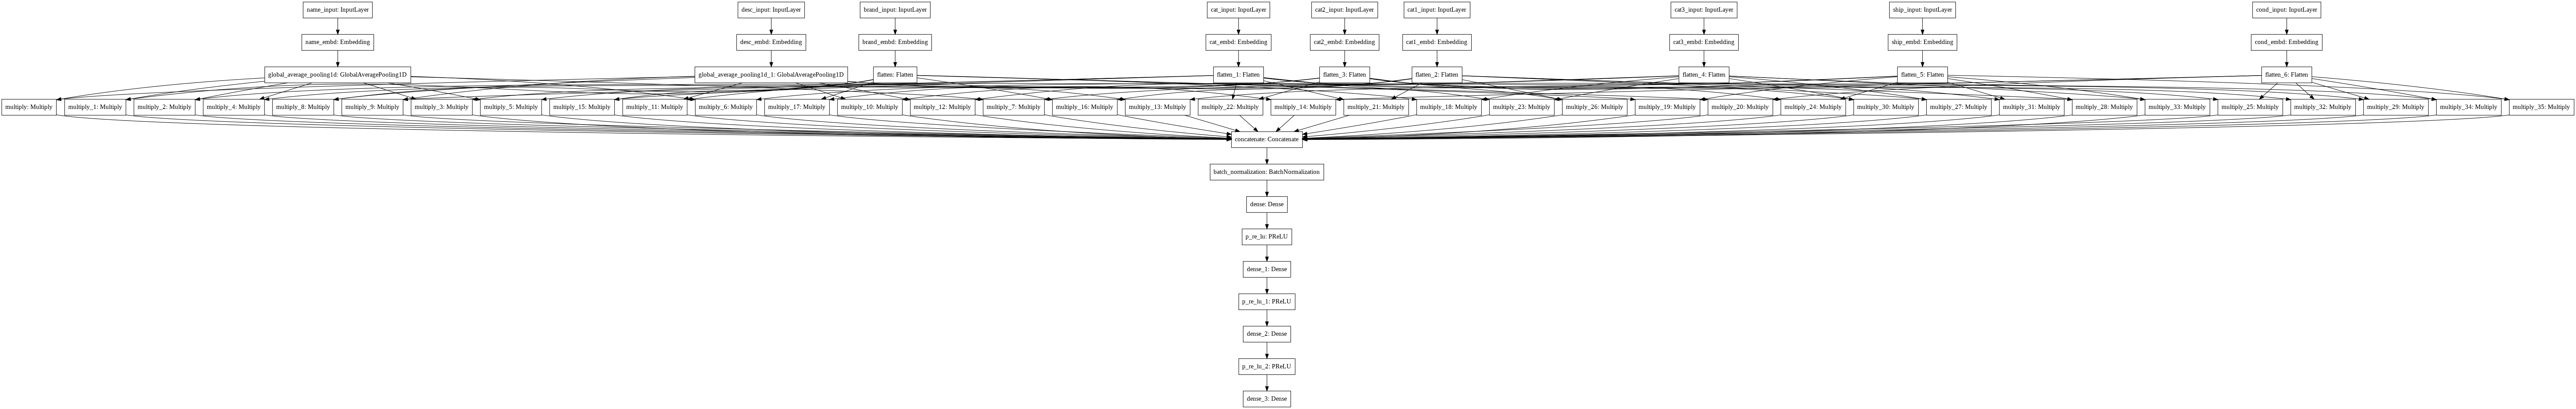

In [ ]:
plot_model(model, "FM.png")

In [ ]:
# model = createModel()
opt = keras.optimizers.Adam(lr=0.001, decay=0.0002, clipnorm=1.0)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
for batch in [8000, 4000, 2000, 1000, 500, 250]:

  model.fit(X_train, y, batch_size=batch, epochs=1,
                               verbose=1,
                              validation_data=(X_test, y_test), shuffle=False,callbacks=[])

4742/4742 [==============================] - 410s 87ms/step - loss: 0.1636 - root_mean_squared_error: 0.3898 - val_loss: 0.1995 - val_root_mean_squared_error: 0.4350


In [ ]:
del model

In [ ]:

y_test_pred = model.predict(X_test)
RMSLE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
RMSLE_test

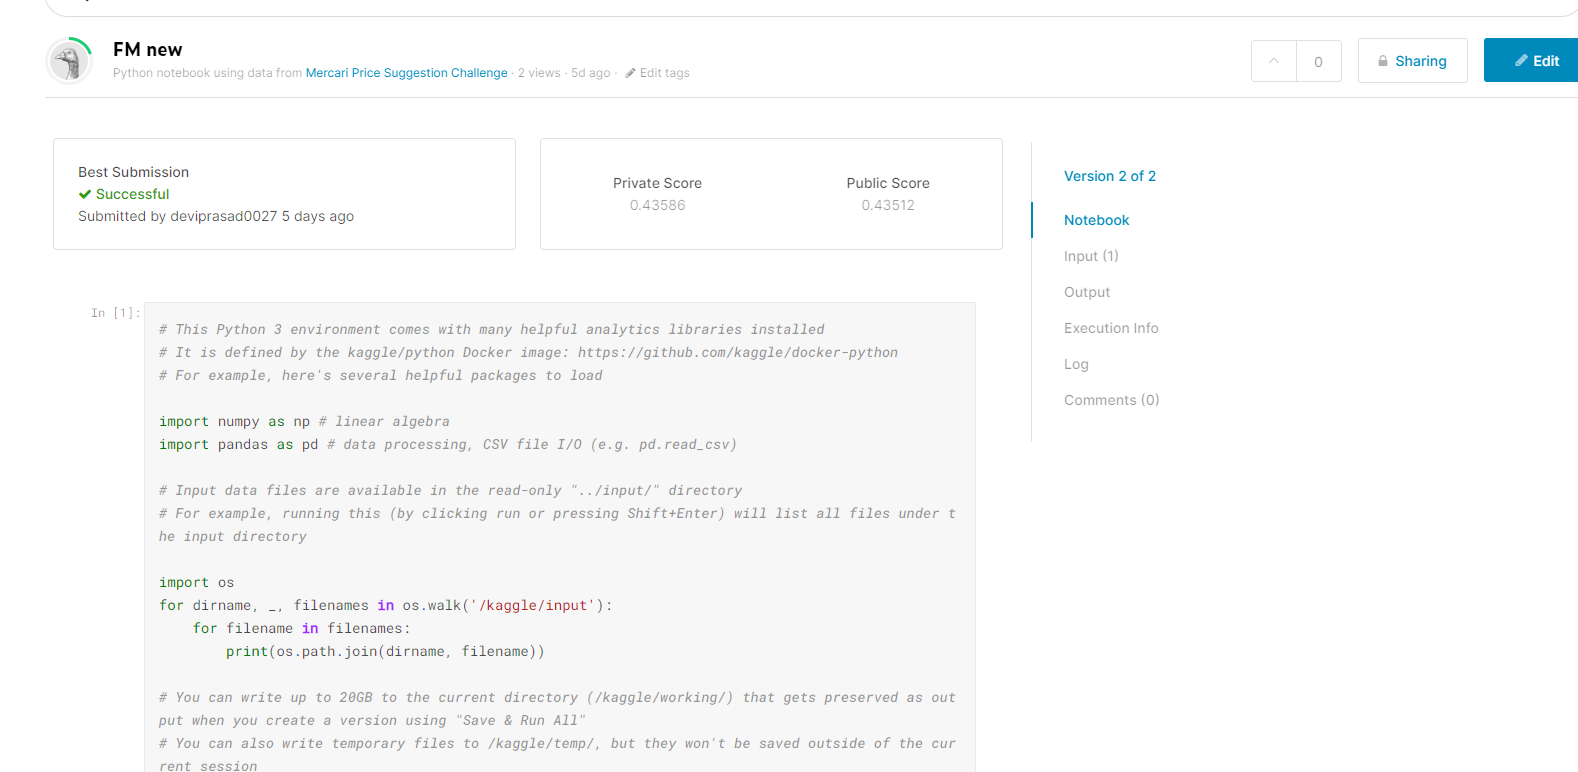

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/CASE STUDY - 1/submission/Factorization Machine/FM Model.PNG")

## LSTM Model

In [ ]:
train_df['category_name'] = train_df['category_name'].replace(r'\s+', "_", regex=True)
test_df['category_name'] = test_df['category_name'].replace(r'\s+', "_", regex=True)

In [ ]:
train_df['category_name']

0                                        kids_boys_4_bottoms
1                                          other_other_other
2                          beauty_hair_care_styling_products
3                                   women_pants_casual_pants
4                                    women_underwear_panties
                                 ...                        
1186023                                 kids_girls_4_dresses
1186024                          women_tops_blouses_knit_top
1186025                          kids_toys_dolls_accessories
1186026    electronics_cell_phones_accessories_cables_ada...
1186027    electronics_cell_phones_accessories_cell_phone...
Name: category_name, Length: 1185332, dtype: object

In [ ]:
class CustomTokenizer():

  def __init__(self, min_df, max_len):
    self.min_df = min_df
    self.vect = CountVectorizer(lowercase=True, ngram_range=(1,1), stop_words='english', min_df=self.min_df, )
    self.vocabulary = None
    self.max_len = max_len

  def fit(self, corpus):
    self.vect.fit(corpus)
    self.vocabulary = self.vect.vocabulary_

  def transform(self, corpus):
    """
    from a sentence the words with min_freq=self.min_df will be kept, then will be transformed to sequence
    """
    trans_seq = []

    for sent in corpus:

      tokens = sent.lower().split()
      new_sent = []

      for token in tokens:
        if token in self.vocabulary:
          new_sent.append(self.vocabulary[token])
      ## padding
      if len(new_sent) > self.max_len:
        trans_seq.append(np.array(new_sent[:self.max_len]))
      else:
        while len(new_sent) != self.max_len:
          new_sent.append(0)
        trans_seq.append(np.array(new_sent))

    return np.array(trans_seq)

  def getVocab(self):
    return self.vocabulary
        

In [ ]:
tr = train_df['name'] 
te = test_df['name']

tokenizer = CustomTokenizer(min_df=30, max_len=8)

tokenizer.fit(tr)
vocab_name = len(tokenizer.getVocab()) + 1

train_name_padded = tokenizer.transform(tr)
test_name_padded  = tokenizer.transform(te)


In [ ]:
## desc

In [ ]:
tr = train_df['item_description'] 
te = test_df['item_description']

tokenizer = CustomTokenizer(min_df=30, max_len=160)

tokenizer.fit(tr)
vocab_desc = len(tokenizer.getVocab()) + 1

train_desc_padded = tokenizer.transform(tr)
test_desc_padded  = tokenizer.transform(te)


In [ ]:
## brand name

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['brand_name'] 
te = test_df['brand_name'] 

tokenizer.fit_on_texts(tr)

vocab_brand = len(tokenizer.word_index)+1

train_brand = tokenizer.texts_to_sequences(tr)
test_brand  = tokenizer.texts_to_sequences(te)

train_brand_padded = pad_sequences(train_brand, maxlen=1, padding='post')
test_brand_padded = pad_sequences(test_brand, maxlen=1, padding='post')


In [ ]:
## cat

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['category_name'] 
te = test_df['category_name'] 

tokenizer.fit_on_texts(tr)

vocab_cat = len(tokenizer.word_index)+1

train_cat = tokenizer.texts_to_sequences(tr)
test_cat  = tokenizer.texts_to_sequences(te)

train_cat_padded = pad_sequences(train_cat, maxlen=1, padding='post')
test_cat_padded = pad_sequences(test_cat, maxlen=1, padding='post')


In [ ]:
## cat1

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['cat_1'] 
te = test_df['cat_1'] 

tokenizer.fit_on_texts(tr)

vocab_cat1 = len(tokenizer.word_index)+1

train_cat1 = tokenizer.texts_to_sequences(tr)
test_cat1  = tokenizer.texts_to_sequences(te)

train_cat1_padded = pad_sequences(train_cat1, maxlen=1, padding='post')
test_cat1_padded = pad_sequences(test_cat1, maxlen=1, padding='post')


In [ ]:
## cat2

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['cat_2'] 
te = test_df['cat_2'] 

tokenizer.fit_on_texts(tr)

vocab_cat2 = len(tokenizer.word_index)+1

train_cat2 = tokenizer.texts_to_sequences(tr)
test_cat2  = tokenizer.texts_to_sequences(te)

train_cat2_padded = pad_sequences(train_cat2, maxlen=1, padding='post')
test_cat2_padded = pad_sequences(test_cat2, maxlen=1, padding='post')


In [ ]:
## cat3

In [ ]:
tokenizer = Tokenizer(num_words=None,
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',
                    lower=True,
                    split=' ',
                    char_level=False,
                    oov_token="<UNK>",
                    document_count=0,)
tr = train_df['cat_3'] 
te = test_df['cat_3'] 

tokenizer.fit_on_texts(tr)

vocab_cat3 = len(tokenizer.word_index)+1

train_cat3 = tokenizer.texts_to_sequences(tr)
test_cat3  = tokenizer.texts_to_sequences(te)

train_cat3_padded = pad_sequences(train_cat3, maxlen=1, padding='post')
test_cat3_padded = pad_sequences(test_cat3, maxlen=1, padding='post')


In [ ]:
## ship

In [ ]:

train_shipping = train_df['shipping'].to_numpy().reshape(-1,1)
test_shipping  = test_df['shipping'].to_numpy().reshape(-1, 1)


In [ ]:
## cond

In [ ]:

train_cond = train_df['item_condition_id'].to_numpy().reshape(-1,1)
test_cond  = test_df['item_condition_id'].to_numpy().reshape(-1, 1)


In [ ]:
## desc word count

In [ ]:
from sklearn.preprocessing import StandardScaler
vect = StandardScaler()

tr = (train_df['item_description'].str.count("\s+")+1).fillna(0).astype(np.int64)
te = (test_df['item_description'].str.count("\s+")+1).fillna(0).astype(np.int64)
## vect.fit_transform(tr.to_numpy().reshape(-1, 1))
## vect.transform(te.to_numpy().reshape(-1, 1))

train_desc_wc = tr.to_numpy().reshape(-1,1)
test_desc_wc = te.to_numpy().reshape(-1,1)

In [ ]:
## name word count

In [ ]:
from sklearn.preprocessing import StandardScaler
vect = StandardScaler()

tr = (train_df['name'].str.count("\s+")+1).fillna(0).astype(np.int64)
te = (test_df['name'].str.count("\s+")+1).fillna(0).astype(np.int64)
## vect.fit_transform(tr.to_numpy().reshape(-1, 1))
## vect.transform(te.to_numpy().reshape(-1, 1))

train_name_wc = tr.to_numpy().reshape(-1, 1)
test_name_wc = te.to_numpy().reshape(-1, 1)

In [ ]:
# train_cat_padded, test_cat_padded

X_train = [train_name_padded, train_desc_padded,
           
           train_brand_padded, train_cat_padded,
           
           train_cat1_padded, train_cat2_padded, train_cat3_padded,
           
           train_shipping, train_cond,
           
           ]


X_test = [test_name_padded, test_desc_padded,
          
          test_brand_padded, test_cat_padded,
          
          test_cat1_padded, test_cat2_padded, test_cat3_padded,
          
          test_shipping, test_cond,]



In [ ]:
## MODEL (LSTM)

In [ ]:
tf.keras.backend.clear_session()


name = Input(shape=(8,), name="name")
desc = Input(shape=(160,), name="desc")
brand = Input(shape=(1,), name="brand")
cat = Input(shape=(1,), name="cat")
cat1 = Input(shape=(1,), name="cat1")
cat2 = Input(shape=(1,), name="cat2")
cat3 = Input(shape=(1,), name="cat3")
ship = Input(shape=(1,), name="ship")
cond = Input(shape=(1,), name="cond")

name_embd = Embedding(input_dim=vocab_name, output_dim=35, name="name_embd") (name)
desc_embd = Embedding(input_dim=vocab_desc, output_dim=45, name="desc_embd") (desc)
brand_embd = Embedding(input_dim=vocab_brand, output_dim=10, name="brand_embd") (brand)
cat_embd = Embedding(input_dim=vocab_cat, output_dim=10, name="cat_embd") (cat)
cat1_embd = Embedding(input_dim=vocab_cat1, output_dim=10, name="cat1_embd") (cat1)
cat2_embd = Embedding(input_dim=vocab_cat2, output_dim=10, name="cat2_embd") (cat2)
cat3_embd = Embedding(input_dim=vocab_cat3, output_dim=10, name="cat3_embd") (cat3)
ship_embd = Embedding(input_dim=3, output_dim=10, name="ship_embd") (ship)
cond_embd = Embedding(input_dim=6, output_dim=10, name="cond_embd") (cond)

name_lstm = GRU(units=30, )(name_embd)
desc_lstm = GRU(units=50, )(desc_embd)

brand_flat = Flatten()(brand_embd)
# cat_flat = GlobalAveragePooling1D()(cat_embd)
cat1_flat = Flatten()(cat1_embd)
cat2_flat = Flatten()(cat2_embd)
cat3_flat = Flatten()(cat3_embd)
ship_flat = Flatten()(ship_embd)
cond_flat = Flatten()(cond_embd)

# cat_flat

concat = concatenate(inputs=[name_lstm, desc_lstm, brand_flat, cat1_flat, cat2_flat, cat3_flat, ship_flat, cond_flat,])
out = BatchNormalization() (concat)

out = Dense(units=512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)) (concat)
out = BatchNormalization() (out)

out = Dense(units=128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)) (concat)
out = BatchNormalization() (out)

out = Dense(units=64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001)) (concat)
out = BatchNormalization() (out)

out = Dense(units=1, kernel_initializer='normal')(out)


model = Model([name, desc, brand,cat, cat1, cat2, cat3, ship, cond,], out)


model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 8)]          0                                            
__________________________________________________________________________________________________
desc (InputLayer)               [(None, 160)]        0                                            
__________________________________________________________________________________________________
brand (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat1 (InputLayer)               [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
opt = keras.optimizers.Adam(lr=0.002)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
for batch in [2000, 2000, 1000, 1000, 1000, 1000]:

  model.fit(X_train, y, batch_size=batch, epochs=1,
                                    verbose=1,
                                    validation_data=(X_test, y_test),
                                  shuffle=True,callbacks=[])

1186/1186 [==============================] - 104s 88ms/step - loss: 0.1981 - root_mean_squared_error: 0.4427 - val_loss: 0.2251 - val_root_mean_squared_error: 0.4723


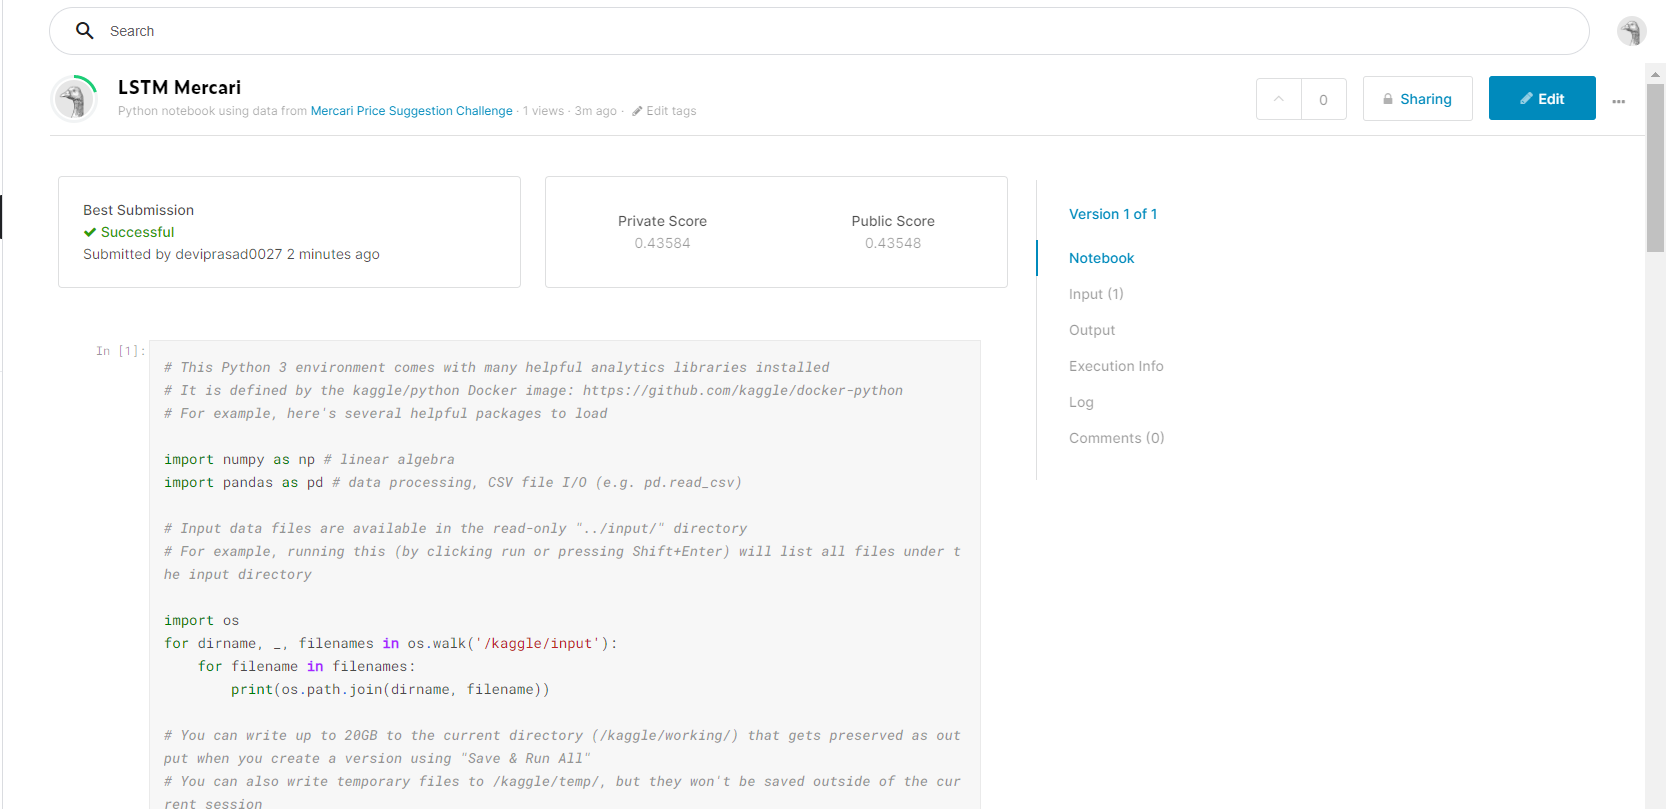

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/CASE STUDY - 1/submission/LSTM Model/Capture.PNG")

# ML Model -- Vectorization

In [ ]:
train_df['name_and_brand_name_and_desc'] = train_df['name'].fillna("") + " " + train_df['brand_name'].fillna("") + " " + train_df['item_description'].fillna("")
        
test_df['name_and_brand_name_and_desc'] = test_df['name'].fillna("") + " " + test_df['brand_name'].fillna("") + " " + test_df['item_description'].fillna("")

In [ ]:
np.unique(train_df['brand_cond']).shape

In [ ]:
## Name

In [ ]:
## TF-IDF Name

vect = TfidfVectorizer(min_df=10, max_features=100000, ngram_range=(1, 3), stop_words='english')

train_name_tfidf = vect.fit_transform(train_df['name'])
test_name_tfidf = vect.transform(test_df['name'])

print("train {}".format(train_name_tfidf.shape))
print("test {}".format(test_name_tfidf.shape))

train (1185332, 78092)
test (296329, 78092)


In [ ]:
## description

In [ ]:
## desc tfidf

vect = TfidfVectorizer(min_df=10, max_features=100000, ngram_range=(1, 3), stop_words='english')

train_desc_tfidf = vect.fit_transform(train_df['item_description'])
test_desc_tfidf = vect.transform(test_df['item_description'])

print("train {}".format(train_desc_tfidf.shape))
print("test {}".format(test_desc_tfidf.shape))



train (1185332, 100000)
test (296329, 100000)


In [ ]:
## name + desc tfidf

In [ ]:
vect = TfidfVectorizer(min_df=10, max_features=100000, ngram_range=(1, 3), stop_words='english')

tr = train_df['item_description'] + " " + train_df['name']
te = test_df['item_description'] + " " + test_df['name']

train_name_desc_tfidf = vect.fit_transform(tr)
test_name_desc_tfidf = vect.transform(te)

print("train {}".format(train_name_desc_tfidf.shape))
print("test {}".format(test_name_desc_tfidf.shape))

train (1185332, 100000)
test (296329, 100000)


In [ ]:
## brand name

In [ ]:
vect = sklearn.preprocessing.LabelBinarizer(sparse_output=True)

train_brand = vect.fit_transform(train_df['brand_name'])
test_brand = vect.transform(test_df['brand_name'])


In [ ]:
## category name

In [ ]:
vect = sklearn.preprocessing.LabelBinarizer(sparse_output=True)

train_df['category_name'] = train_df['category_name'].replace("\s+", "_", regex=True)
test_df['category_name'] = test_df['category_name'].replace("\s+", "_", regex=True)

train_cat_ohe = vect.fit_transform(train_df['category_name'])
test_cat_ohe = vect.transform(test_df['category_name'])

print("train {}".format(train_cat_ohe.shape))
print("test {}".format(test_cat_ohe.shape))

train (1185332, 2017)
test (296329, 2017)


In [ ]:
## cat 1

In [ ]:
vect = sklearn.preprocessing.LabelBinarizer(sparse_output=True)

train_cat_1_ohe = vect.fit_transform(train_df['cat_1'])
test_cat_1_ohe = vect.transform(test_df['cat_1'])

print("train {}".format(train_cat_1_ohe.shape))
print("test {}".format(test_cat_1_ohe.shape))

train (1185332, 11)
test (296329, 11)


In [ ]:
## cat 2

In [ ]:
vect = sklearn.preprocessing.LabelBinarizer(sparse_output=True)

train_cat_2_ohe = vect.fit_transform(train_df['cat_2'])
test_cat_2_ohe = vect.transform(test_df['cat_2'])

print("train {}".format(train_cat_2_ohe.shape))
print("test {}".format(test_cat_2_ohe.shape))

train (1185332, 113)
test (296329, 113)


In [ ]:
## cat 3

In [ ]:
vect = sklearn.preprocessing.LabelBinarizer(sparse_output=True)

train_cat_3_ohe = vect.fit_transform(train_df['cat_3'])
test_cat_3_ohe = vect.transform(test_df['cat_3'])

print("train {}".format(train_cat_3_ohe.shape))
print("test {}".format(test_cat_3_ohe.shape))

train (1185332, 861)
test (296329, 861)


In [ ]:
## item cond id

In [ ]:
vect = sklearn.preprocessing.OneHotEncoder()

train_cond_ohe = vect.fit_transform(train_df['item_condition_id'].to_numpy().reshape(-1, 1))
test_cond_ohe = vect.transform(test_df['item_condition_id'].to_numpy().reshape(-1, 1))

print("train {}".format(train_cond_ohe.shape))
print("test {}".format(test_cond_ohe.shape))

train (1185332, 5)
test (296329, 5)


In [ ]:
## shipping

In [ ]:
vect = sklearn.preprocessing.OneHotEncoder()

train_shipping_ohe = vect.fit_transform(train_df['shipping'].to_numpy().reshape(-1, 1))
test_shipping_ohe = vect.transform(test_df['shipping'].to_numpy().reshape(-1, 1))

print("train {}".format(train_shipping_ohe.shape))
print("test {}".format(test_shipping_ohe.shape))

train (1185332, 2)
test (296329, 2)


In [ ]:
## desc word count

In [ ]:
## desc char count

In [ ]:

vect = sklearn.preprocessing.MinMaxScaler()

train_desc_char_count = vect.fit_transform(train_df['desc_char_count'].to_numpy().reshape(-1, 1))
test_desc_char_count = vect.transform(test_df['desc_char_count'].to_numpy().reshape(-1, 1))

In [ ]:
## desc word count

In [ ]:

vect = sklearn.preprocessing.MinMaxScaler()

train_desc_word_count = vect.fit_transform(train_df['desc_word_count'].to_numpy().reshape(-1, 1))
test_desc_word_count = vect.transform(test_df['desc_word_count'].to_numpy().reshape(-1, 1))

In [ ]:
## name word count

vect = sklearn.preprocessing.MinMaxScaler()

train_name_word_count = vect.fit_transform(train_df['name_word_count'].to_numpy().reshape(-1, 1))
test_name_word_count = vect.transform(test_df['name_word_count'].to_numpy().reshape(-1, 1))

In [ ]:
## name char count

In [ ]:
vect = sklearn.preprocessing.MinMaxScaler()

train_name_char_count = vect.fit_transform(train_df['name_char_count'].to_numpy().reshape(-1, 1))
test_name_char_count = vect.transform(test_df['name_char_count'].to_numpy().reshape(-1, 1))

In [ ]:
# brand_mean_price

In [ ]:

train_df['brand_mean_price'] = train_df['brand_name'].map(train_df.groupby(['brand_name'])['log_price'].mean().astype(np.float32)).astype(np.float32)


test_df['brand_mean_price'] = test_df['brand_name'].map(train_df.groupby(['brand_name'])['log_price'].mean().astype(np.float32))
                                                                                    .fillna(train_df['brand_mean_price'].values.mean()).astype(np.float32)
                                                                                    



In [ ]:
tr = train_df['brand_mean_price'].values.reshape(-1, 1)
te = test_df['brand_mean_price'].values.reshape(-1, 1)


train_brand_mean_price = tr / np.max(tr)
test_brand_mean_price = te / np.max(tr)


In [ ]:
## category_name price mean

In [ ]:
train_df['cat_mean_price'] = train_df['category_name'].map(train_df.groupby(['category_name'])['log_price'].mean().astype(np.float32)).astype(np.float32)
test_df['cat_mean_price'] = test_df['category_name'].map(train_df.groupby(['category_name'])['log_price'].mean().astype(np.float32)).fillna(train_df['cat_mean_price'].values.mean()).astype(np.float32)

In [ ]:
tr = train_df['cat_mean_price'].values.reshape(-1, 1)
te = test_df['cat_mean_price'].values.reshape(-1, 1)


train_cat_mean_price = tr / np.max(tr)
test_cat_mean_price = te / np.max(tr)

In [ ]:
## cat1 price mean

In [ ]:
train_df['cat1_mean_price'] = train_df['cat_1'].map(train_df.groupby(['cat_1'])['log_price'].mean().astype(np.float32)).astype(np.float32)
test_df['cat1_mean_price'] = test_df['cat_1'].map(train_df.groupby(['cat_1'])['log_price'].mean().astype(np.float32)).fillna(train_df['cat1_mean_price'].values.mean()).astype(np.float32)

In [ ]:
tr = train_df['cat1_mean_price'].values.reshape(-1, 1)
te = test_df['cat1_mean_price'].values.reshape(-1, 1)


train_cat1_mean_price = tr / np.max(tr)
test_cat1_mean_price = te / np.max(tr)

In [ ]:
## cat2 price mean

In [ ]:
train_df['cat2_mean_price'] = train_df['cat_2'].map(train_df.groupby(['cat_2'])['log_price'].mean().astype(np.float32)).astype(np.float32)
test_df['cat2_mean_price'] = test_df['cat_2'].map(train_df.groupby(['cat_2'])['log_price'].mean().astype(np.float32)).fillna(train_df['cat2_mean_price'].values.mean()).astype(np.float32)

In [ ]:
tr = train_df['cat2_mean_price'].values.reshape(-1, 1)
te = test_df['cat2_mean_price'].values.reshape(-1, 1)


train_cat2_mean_price = tr / np.max(tr)
test_cat2_mean_price = te / np.max(tr)

In [ ]:
## cat3 price mean

In [ ]:
train_df['cat3_mean_price'] = train_df['cat_3'].map(train_df.groupby(['cat_3'])['log_price'].mean().astype(np.float32)).astype(np.float32)
test_df['cat3_mean_price'] = test_df['cat_3'].map(train_df.groupby(['cat_3'])['log_price'].mean().astype(np.float32)).fillna(train_df['cat3_mean_price'].values.mean()).astype(np.float32)

In [ ]:
tr = train_df['cat3_mean_price'].values.reshape(-1, 1)
te = test_df['cat3_mean_price'].values.reshape(-1, 1)


train_cat3_mean_price = tr / np.max(tr)
test_cat3_mean_price = te / np.max(tr)

In [ ]:
## Concatenating vectors

In [ ]:

# train_desc_tfidf, train_name_tfidf,
# test_desc_tfidf, test_name_tfidf,

X_train = hstack((

    train_shipping_ohe, train_cond_ohe,
    
    train_desc_tfidf, train_name_tfidf,
    
    train_cat_3_ohe, train_cat_2_ohe, train_cat_1_ohe,

    train_desc_word_count, train_name_word_count,

    train_desc_char_count, train_name_char_count,

    train_brand_mean_price, train_cat_mean_price,

    train_cat1_mean_price, train_cat2_mean_price, train_cat3_mean_price,

    train_name_desc_tfidf

))


X_test = hstack((
    
    test_shipping_ohe, test_cond_ohe,
    
    test_desc_tfidf, test_name_tfidf,
    
    test_cat_3_ohe, test_cat_2_ohe, test_cat_1_ohe, 

    test_desc_word_count, test_name_word_count,

    test_desc_char_count, test_name_char_count,

    test_brand_mean_price, test_cat_mean_price,

    test_cat1_mean_price, test_cat2_mean_price, test_cat3_mean_price,

    test_name_desc_tfidf

))

gc.collect()

X_train.shape, X_test.shape

((1185332, 279093), (296329, 279093))

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection.univariate_selection import f_regression

selector  = SelectKBest(score_func=f_regression, k=180000)

X_train = selector.fit_transform(X_train, y)
X_test = selector.transform(X_test)

## Ridge Regressor

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
for alpha in [4,3.1, 3.2, 3.3, 3.4, 3.5]:
  ridgeReg = Ridge(solver = "auto", fit_intercept=True, alpha=alpha)
  ridgeReg.fit(X_train, y)

  y_test_pred = ridgeReg.predict(X_test)
  RMSLE = np.sqrt(mean_squared_error(y_test, y_test_pred))
  
  gc.collect()
  print("alpha : {} ---> RMSLE {}".format(alpha, RMSLE))

In [ ]:
  ## added new features : desc_word_count, name_word_count
  ## TF-IDF name, desc
  
  ridgeReg = Ridge(solver = "auto", fit_intercept=True, alpha=3.1)
  ridgeReg.fit(X_train, y)

  y_test_pred = ridgeReg.predict(X_test)
  RMSLE = np.sqrt(mean_squared_error(y_test, y_test_pred))
  
  gc.collect()
  print("alpha : {} ---> RMSLE {}".format(3.1, RMSLE))

alpha : 3.1 ---> RMSLE 0.44645187199411224


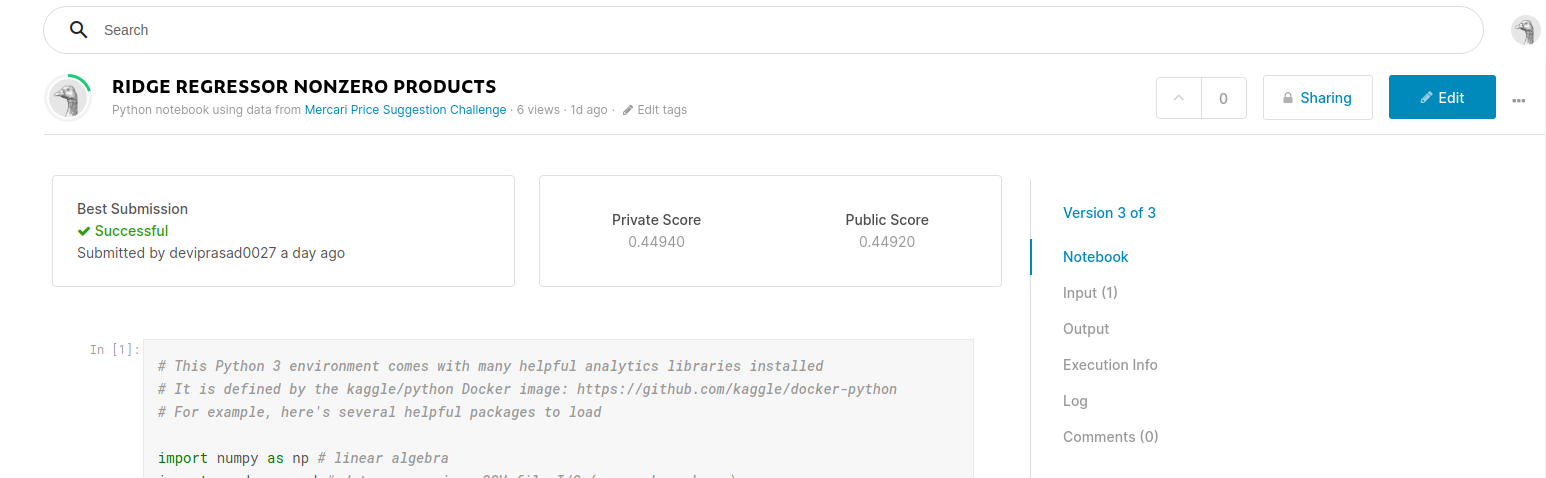

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/CASE STUDY - 1/submission/ridge regression/ridge regressor.png")

## Light GBM

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:


for estm in [20, 50, 100, 200, 300, 500, 700]:
  lgbm_model = LGBMRegressor(n_estimators=estm,)

  lgbm_model.fit(X_train, y)
  y_test_pred = lgbm_model.predict(X_test)

  RMSLE = np.sqrt(mean_squared_error(y_test, y_test_pred))

  gc.collect()

  print("estimator {} ----> RMSLE: {}".format(estm, RMSLE))


estimator 20 ----> RMSLE: 0.5615902162543063
estimator 50 ----> RMSLE: 0.5278645540096235
estimator 100 ----> RMSLE: 0.5084262508559101
estimator 200 ----> RMSLE: 0.4912459178649339
estimator 300 ----> RMSLE: 0.4814558466427265
estimator 500 ----> RMSLE: 0.46947170010955475
estimator 700 ----> RMSLE: 0.4620357688855301


In [ ]:
for estm in [2000]:
  lgbm_model = LGBMRegressor(n_estimators=estm,)

  lgbm_model.fit(X_train, y)
  y_test_pred = lgbm_model.predict(X_test)

  RMSLE = np.sqrt(mean_squared_error(y_test, y_test_pred))

  gc.collect()

  print("estimator {} ----> RMSLE: {}".format(estm, RMSLE))

estimator 2000 ----> RMSLE: 0.4416323439078127


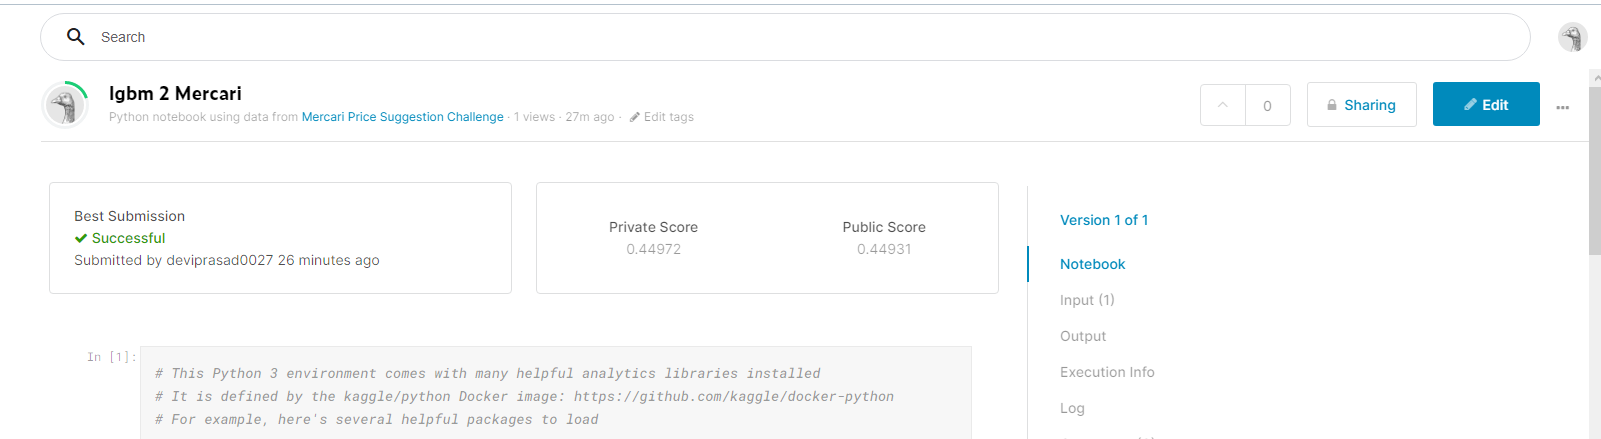

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/CASE STUDY - 1/submission/lgbm/Capture.PNG') 